In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Загружаем данные 

In [32]:
def load_data(path):
    df = pd.read_csv(path)
    df.drop(["Id"], axis="columns", inplace=True)
    return df

In [33]:
train_df_initial = load_data("train.csv")
train_df_initial.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


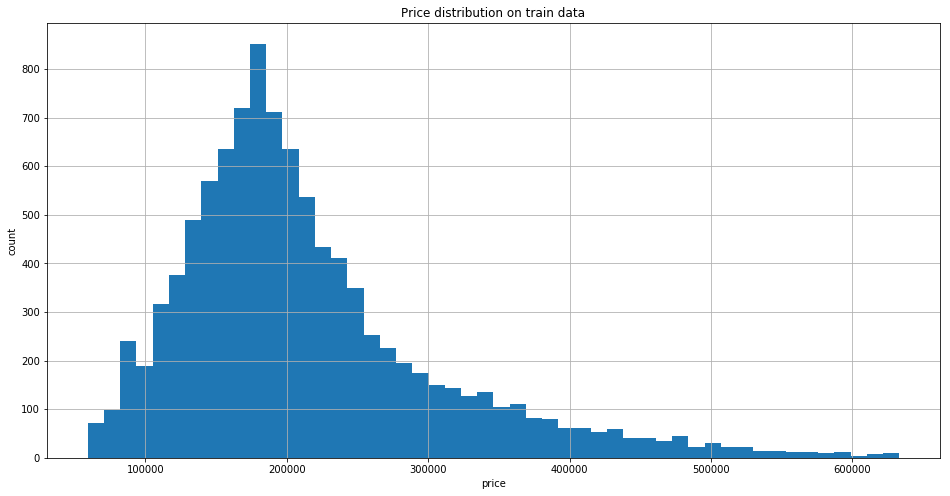

In [34]:
plt.figure(figsize = (16, 8))

train_df_initial["Price"].hist(bins=50)
plt.ylabel("count")
plt.xlabel("price")

plt.title("Price distribution on train data")
plt.show()

# Очищаем и заполняем отсутствующие признаки

In [35]:
def get_dummied_df(df):
    df = pd.concat([df, pd.get_dummies(df["Ecology_2"], prefix="Ecology_2")], axis=1)
    df = pd.concat([df, pd.get_dummies(df["Ecology_3"], prefix="Ecology_3")], axis=1)
    df = pd.concat([df, pd.get_dummies(df["Shops_2"], prefix="Shops_2")], axis=1)
    return df

train_df = get_dummied_df(train_df_initial)
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,...,0,11,B,184966.930730,0,1,0,1,0,1
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,...,1,16,B,300009.450063,0,1,0,1,0,1
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,...,1,3,B,220925.908524,0,1,0,1,0,1
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,...,0,5,B,175616.227217,0,1,0,1,0,1
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,...,2,4,B,150226.531644,0,1,0,1,0,1


In [36]:
# выставляем критерии корректности данных

MIN_LIFE_SQUARE = 10
MIN_KITCHEN_SQUARE = 3
MIN_WHOLE_SQUARE = 15
MAX_WHOLE_SQUARE = 220
MAX_NUMBER_OF_ROOMS = 5

In [37]:
# устанавливаем некорректные, на наш взляд, данные в NaN, чтобы они не влияли на вычисление среднего 
def fill_wrong_whole_square_param_with_nans(df, min_whole_square, max_whole_square):
    df.loc[(df['Square'] < min_whole_square) | (df['Square'] > max_whole_square), 'Square'] = np.nan
    return df

train_df = fill_wrong_whole_square_param_with_nans(train_df, MIN_WHOLE_SQUARE, MAX_WHOLE_SQUARE)

# этот и последующие коэффициенты будут использоваться для test выборки
square_coef = (train_df.loc[(train_df["Rooms"] != 0) & (train_df["Rooms"] <= MAX_NUMBER_OF_ROOMS), "Square"] /
               train_df.loc[(train_df["Rooms"] != 0) & (train_df["Rooms"] <= MAX_NUMBER_OF_ROOMS), "Rooms"]).mean()
                     

def fill_wrong_whole_square_param(df, square_coef):
    df.loc[np.isnan(df["Square"]), "Square"] = df.loc[np.isnan(df["Square"]), "Rooms"] * square_coef
    df.loc[df["Square"] == 0, "Square"] = df["Square"].mean()
    return df

train_df = fill_wrong_whole_square_param(train_df, square_coef)

In [38]:
def fill_wrong_square_params_with_nans(df, min_life_sqare, min_kitchen_sqare):
    df.loc[df['LifeSquare'] < min_life_sqare, 'LifeSquare'] = np.nan
    df.loc[df['KitchenSquare'] < min_kitchen_sqare, 'KitchenSquare'] = np.nan
    df.loc[df["KitchenSquare"] + df["LifeSquare"] > df["Square"], ["KitchenSquare", "LifeSquare"]] = np.nan
    return df

train_df = fill_wrong_square_params_with_nans(train_df, MIN_LIFE_SQUARE, MIN_KITCHEN_SQUARE)

life_coeff = (train_df["LifeSquare"] / train_df["Square"]).mean()
kitch_coeff = (train_df["KitchenSquare"] / train_df["Square"]).mean()

def fill_wrong_square_params(df, life_coeff, kitch_coeff):
    df.loc[np.isnan(df["LifeSquare"]), "LifeSquare"] = df.loc[np.isnan(df["LifeSquare"]), "Square"] * life_coeff
    df.loc[np.isnan(df["KitchenSquare"]), "KitchenSquare"] = df.loc[np.isnan(df["KitchenSquare"]), "Square"] * kitch_coeff
    return df

train_df = fill_wrong_square_params(train_df, life_coeff, kitch_coeff)

In [39]:
def fill_wrong_rooms_param_with_nans(df, max_rooms):
    df.loc[(df["Rooms"] == 0) | (df["Rooms"] > max_rooms), "Rooms"] = np.nan
    return df

train_df = fill_wrong_rooms_param_with_nans(train_df, MAX_NUMBER_OF_ROOMS)

room_coef = (train_df["Rooms"] / train_df["Square"]).mean()

def fill_wrong_rooms_param(df, room_coef):
    df.loc[np.isnan(df["Rooms"]), "Rooms"] = np.round_(room_coef * df.loc[np.isnan(df["Rooms"]), "Square"])
    return df
    
train_df = fill_wrong_rooms_param(train_df, room_coef)

In [40]:
# если этаж квартиры, больше чем этажей в доме, поступаем следующим образом:
# находим все дома, с количеством этажей больше, чем этаж данной квартиры и вычисляем срденее среди всех этих значений
def fill_wrong_house_floor_param(df):
    wrong_hfloors = df[df["Floor"] > df["HouseFloor"]]
    result = [ round((df[df["HouseFloor"] > floor]["HouseFloor"]).mean()) for floor in wrong_hfloors["Floor"]]
    df.loc[df["Floor"] > df["HouseFloor"], "HouseFloor"] = result
    return df

train_df = fill_wrong_house_floor_param(train_df)

In [41]:
def fill_wrong_house_year(df):
    df.loc[df["HouseYear"] > 2020, "HouseYear"] = 2020
    return df

train_df = fill_wrong_house_year(train_df)

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# стандартизируем все параметры, кроме целевого (будем использовать линейную регрессию для заполнения Healthcare_1)
features_to_scale = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Ecology_2_A',
       'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A',
       'Shops_2_B']

data_train_for_scaling = scaler.fit_transform(train_df[features_to_scale].astype(float))
train_df = pd.DataFrame(data_train_for_scaling, columns=features_to_scale)
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,-0.353348,0.136323,-0.433707,-0.106979,-0.807679,-0.291306,-0.970393,-0.861908,-0.250529,0.474169,...,-0.127533,NaN,-0.883480,1.408356,-0.09897,0.09897,-0.16816,0.16816,-0.299864,0.299864
1,-0.215687,1.365561,0.498592,0.032569,-0.127596,-0.291306,-0.970393,-0.373187,-0.998053,1.215681,...,-0.295384,-0.883971,-0.213923,2.448700,-0.09897,0.09897,-0.16816,0.16816,-0.299864,0.299864
2,0.059635,0.136323,-0.593475,-0.110204,-0.506128,-0.100498,-0.464840,-0.916210,-0.581588,0.531208,...,-0.337347,-0.894740,-0.213923,-0.256195,-0.09897,0.09897,-0.16816,0.16816,-0.299864,0.299864
3,0.174352,0.136323,-0.150815,-0.031911,-0.068224,-0.100498,0.377750,-0.427489,2.680470,-0.096225,...,-0.211458,-0.057669,-0.883480,0.159943,-0.09897,0.09897,-0.16816,0.16816,-0.299864,0.299864
4,1.115034,-1.092916,-0.872540,-0.181531,-0.467638,0.471924,-0.464840,-0.481792,-0.894969,0.588247,...,-0.295384,0.915487,0.455633,-0.048126,-0.09897,0.09897,-0.16816,0.16816,-0.299864,0.299864


In [43]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=1000, max_depth=25, random_state=100)

# Используем линейную регрессию для отсутсвтующих данных в Healthcare_1 
### небольшой, но все-таки прирост в r2 по сравнению с median или mean

In [44]:
from sklearn.linear_model import LinearRegression

# модель позже будет использоваться для предсказания Healthcare_1 в тестовом наборе
def get_df_with_predicted_healthcare1(df, model=None):
    feature_names_for_health_1 = np.array(['DistrictId',
       'HouseFloor', 'HouseYear', 
       'Social_1', 'Social_2', 'Social_3', 
       'Helthcare_2', 'Shops_1', 'Shops_2_A',
       'Shops_2_B'])
    
    health_1_not_nans = df.loc[~np.isnan(df["Healthcare_1"])]
    X_health_train = pd.DataFrame(health_1_not_nans, columns=feature_names_for_health_1)
    y_health_train = pd.DataFrame(health_1_not_nans, columns=['Healthcare_1'])
    
    health_1_nans = df.loc[np.isnan(df["Healthcare_1"])]
    X_health_pred = pd.DataFrame(health_1_nans, columns=feature_names_for_health_1)
    
    if model is None:
        model = LinearRegression()
        model.fit(X_health_train, y_health_train.values[:, 0])    
    y_health_pred = model.predict(X_health_pred)
    
    df.loc[np.isnan(df["Healthcare_1"]), "Healthcare_1"] = y_health_pred
    
    return df, model 

train_df, health_model = get_df_with_predicted_healthcare1(train_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
DistrictId       10000 non-null float64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null float64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null float64
Ecology_1        10000 non-null float64
Social_1         10000 non-null float64
Social_2         10000 non-null float64
Social_3         10000 non-null float64
Healthcare_1     10000 non-null float64
Helthcare_2      10000 non-null float64
Shops_1          10000 non-null float64
Ecology_2_A      10000 non-null float64
Ecology_2_B      10000 non-null float64
Ecology_3_A      10000 non-null float64
Ecology_3_B      10000 non-null float64
Shops_2_A        10000 non-null float64
Shops_2_B        10000 non-null float64
dtypes: float64(21)
memory usage: 1.6 MB


# Разбиваем тренировочные данные на непосредственно тренировочные и валидационные и оцениваем модель

In [45]:
X_train = pd.DataFrame(train_df, columns=['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Ecology_2_A',
       'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A',
       'Shops_2_B'])
y_train = pd.DataFrame(train_df_initial, columns=["Price"])

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=100)

In [46]:
rfr.fit(X_train, y_train.values[:, 0])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=100, verbose=0, warm_start=False)

In [47]:
y_pred = rfr.predict(X_valid)

In [48]:
check_test = pd.DataFrame({'y_valid': y_valid['Price'], 
                           'y_pred':y_pred.flatten()}, 
                          columns=['y_valid', 'y_pred'])

check_test.head(10)

,y_valid,y_pred
8018,157161.679512,193865.750233
9225,211552.952101,210984.745589
3854,193831.803622,187480.571282
2029,152784.683695,145361.805632
3539,243461.424375,235648.890565
1942,167300.088098,176697.487594
1250,255449.055490,270060.377636
2817,106827.781804,123256.111578
4211,245183.834350,241022.361414
477,325600.765809,240511.592314


In [49]:
from sklearn.metrics import r2_score
r2_score(y_valid, y_pred)

0.7251053286106017

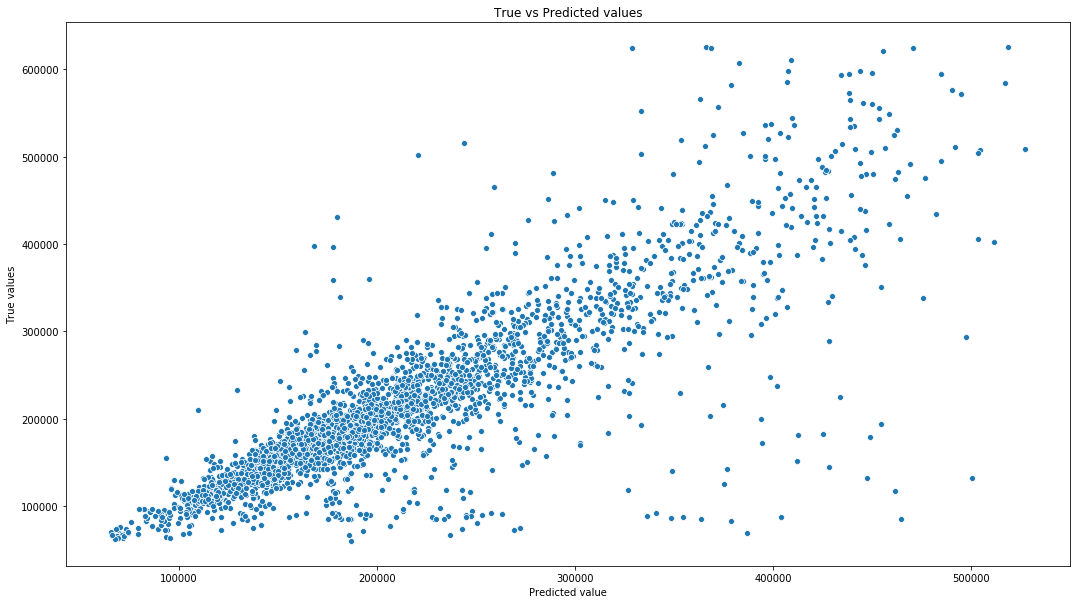

In [50]:
plt.figure(figsize=(18,10))
sns.scatterplot(x=y_pred, y=y_valid.values[:, 0])
plt.xlabel("Predicted value")
plt.ylabel("True values")
plt.title("True vs Predicted values")

plt.show()
# судя по графику, модель лучше работает, при меньших ценах (вероятно, так как в области высоких цен, меньше данных)

# Загружаем тестовые данные

In [51]:
test_df_initial = pd.read_csv("test.csv")
test_df = test_df_initial.drop(["Id"], axis="columns")

In [52]:
test_df = get_dummied_df(test_df_initial)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,NaN,0,0,B,0,1,0,1,0,1
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,...,NaN,0,2,B,0,1,0,1,0,1
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,4702.0,5,5,B,0,1,0,1,0,1
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,NaN,3,3,B,0,1,0,1,0,1
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,NaN,0,0,A,0,1,0,1,1,0


# Очищаем и заполняем отсутствующие данные в тестовой выборке

In [53]:
test_df = fill_wrong_whole_square_param_with_nans(test_df, MIN_WHOLE_SQUARE, MAX_WHOLE_SQUARE)
test_df = fill_wrong_whole_square_param(test_df, square_coef)
test_df = fill_wrong_square_params_with_nans(test_df, MIN_LIFE_SQUARE, MIN_KITCHEN_SQUARE)
test_df = fill_wrong_square_params(test_df, life_coeff, kitch_coeff)
test_df = fill_wrong_rooms_param_with_nans(test_df, MAX_NUMBER_OF_ROOMS)
test_df = fill_wrong_rooms_param(test_df, room_coef)
test_df = fill_wrong_house_floor_param(test_df)
test_df = fill_wrong_house_year(test_df)

In [54]:
data_test_for_scaling = scaler.fit_transform(test_df[features_to_scale].astype(float))
test_df = pd.DataFrame(data_test_for_scaling, columns=features_to_scale)
test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,0.152140,0.113698,-0.350914,-0.233044,-0.794327,-0.480057,-0.109525,-0.667299,1.585280,-0.794834,...,-0.304366,NaN,-0.891612,-0.888194,-0.098453,0.098453,-0.175258,0.175258,-0.299666,0.299666
1,0.514336,0.113698,0.680002,0.578707,0.780912,-0.480057,0.051589,-0.398066,-0.367283,-1.080052,...,-0.220549,NaN,-0.891612,-0.469511,-0.098453,0.098453,-0.175258,0.175258,-0.299666,0.299666
2,3.140252,-1.122155,-1.278328,-1.396670,1.254843,-1.209627,-1.559545,-4.059632,-0.998468,0.288994,...,3.299785,3.403724,2.487242,0.158513,-0.098453,0.098453,-0.175258,0.175258,-0.299666,0.299666
3,-0.096869,0.113698,0.881255,0.998699,0.230258,2.438224,1.179382,1.217331,-0.149940,-0.110311,...,-0.220549,NaN,1.135700,-0.260169,-0.098453,0.098453,-0.175258,0.175258,-0.299666,0.299666
4,-0.549613,-1.122155,-0.476213,0.429464,-0.356495,1.526261,0.373815,1.755796,-0.397445,-1.308227,...,-0.304366,NaN,-0.891612,-0.888194,-0.098453,0.098453,-0.175258,0.175258,3.337053,-3.337053


In [55]:
test_df, model = get_df_with_predicted_healthcare1(test_df, health_model)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
DistrictId       5000 non-null float64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       5000 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null float64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null float64
Ecology_1        5000 non-null float64
Social_1         5000 non-null float64
Social_2         5000 non-null float64
Social_3         5000 non-null float64
Healthcare_1     5000 non-null float64
Helthcare_2      5000 non-null float64
Shops_1          5000 non-null float64
Ecology_2_A      5000 non-null float64
Ecology_2_B      5000 non-null float64
Ecology_3_A      5000 non-null float64
Ecology_3_B      5000 non-null float64
Shops_2_A        5000 non-null float64
Shops_2_B        5000 non-null float64
dtypes: float64(21)
memory usage: 820.4 KB


# Делаем предсказание на тестовой выборке

In [56]:
y_test_pred = rfr.predict(test_df)

In [57]:
result = pd.DataFrame({
    'Id': test_df_initial['Id'],
    'Price':y_test_pred
})

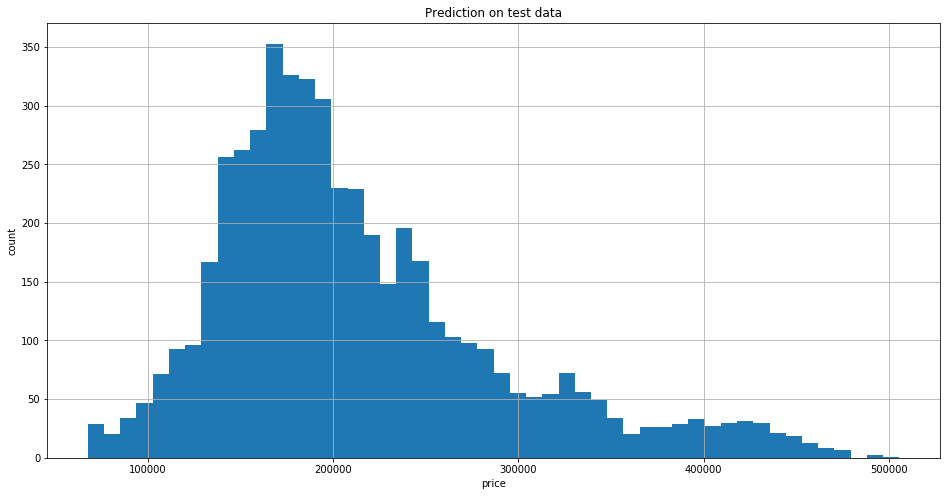

In [58]:
plt.figure(figsize = (16, 8))

result["Price"].hist(bins=50)
plt.ylabel("count")
plt.xlabel("price")

plt.title("Prediction on test data")
plt.show()

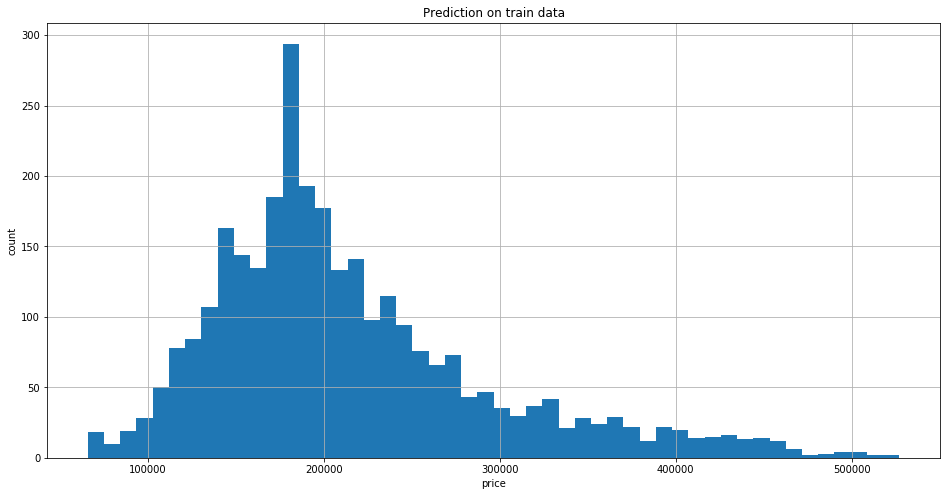

In [59]:
pred = pd.DataFrame({
    'Price':y_pred
})

plt.figure(figsize = (16, 8))

pred["Price"].hist(bins=50)
plt.ylabel("count")
plt.xlabel("price")

plt.title("Prediction on train data")
plt.show()

In [60]:
result.to_csv('ABabkin_predictions.csv', sep=',', index=False, encoding='utf-8')